In [1]:
import torch
from torch import nn
import rdkit
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger
from torch_geometric.data import Dataset, Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn.conv import RGCNConv, FastRGCNConv
from torch_geometric.datasets import QM7b
import time
import datetime
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

In [2]:
import sascorer

In [3]:
torch.set_default_device('cuda')

In [4]:
from constants import *
from utils import *

In [5]:
import  generator as G
import discriminator as D
import rewardnet as R
import mlp as M
import rgcn

In [18]:
zinc250k=pd.read_csv("250k_rndm_zinc_drugs_clean.csv", nrows=10_000)
gdb9=pd.read_csv("gdb9_shuffled.csv", nrows=5_00)
sampled=zinc250k.sample(1000).reset_index(drop=True)

In [7]:
gdb9.head(5)

,smiles,qed,logP
0,CC1C(=O)NC([NH-])=C1N,0.476219,-0.0677
1,C#CCc1cc[nH]c1O,0.531797,0.8960
2,CO[C@H]1[C@H]2O[C@@H](C)[C@]21O,0.521381,-0.4666
3,CCC[C@H]1C[C@H]1C(N)=O,0.601215,0.9079
4,O=C1O[C@H]2[C@H]3CC[C@@H]1[C@H]32,0.441104,0.5678


In [8]:
zinc250k.head(5)

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [19]:
zinc250kmols=zinc250k['smiles'].apply(Chem.MolFromSmiles)

<Axes: ylabel='Frequency'>

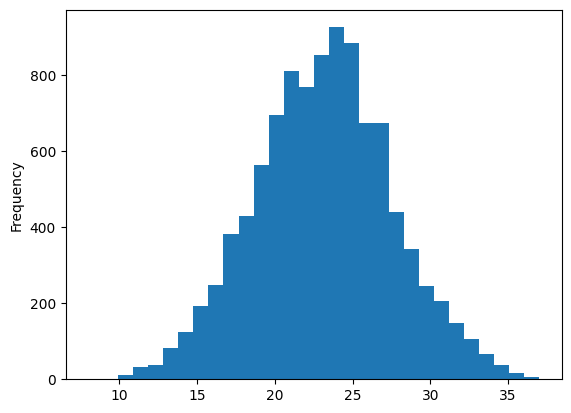

In [56]:
tmp=zinc250kmols.apply(lambda x:x.GetNumAtoms())
tmp.plot.hist(bins=tmp.nunique())

In [57]:
tmp.quantile(0.95)

31.0

In [27]:
(zinc250kmols[0]).GetNumAtoms()

24

In [9]:
logp_scale=zinc250k['logP'].quantile([0.05,0.95]).values
qed_scale=zinc250k['qed'].quantile([0.05,0.95]).values
sas_scale=zinc250k['SAS'].quantile([0.05,0.95]).values

# Atom count (with atomic numbers)
![atom_count](atom_counts.png "Atom Count")

In [10]:
gdb9_dataloader=smiles_to_dataloader(gdb9['smiles'])

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 543.70it/s]


In [11]:
co2=sparse_pyg_graph_from_graph(*graph_remove_zero_bonds(*graph_from_smiles("O=C=O", return_mol=True, typ=torch.float32)))
co2

Data(x=[3, 4], edge_index=[2, 4], edge_attr=[4], molecule=<rdkit.Chem.rdchem.Mol object at 0x0000028BEC7807B0>)

In [58]:
Batch.from_data_list([co2,co2]).to_data_list()

[Data(x=[3, 4], edge_index=[2, 4], edge_attr=[4], molecule=<rdkit.Chem.rdchem.Mol object at 0x0000028BEC7807B0>),
 Data(x=[3, 4], edge_index=[2, 4], edge_attr=[4], molecule=<rdkit.Chem.rdchem.Mol object at 0x0000028BEC7807B0>)]

In [62]:
graph_from_data(co2)

(tensor([[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.]], device='cuda:0'),
 tensor([[[1., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],
 
         [[0., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]], device='cuda:0'))

In [75]:
def expand_graph(x,a,typ=torch.float32):
    assert len(x.shape)==2, "only unbatched single graphs are supported"
    a_has_zero_bonds=a.shape[-3]==len(BONDS)
    assert a_has_zero_bonds or a.shape[-3]==len(BONDS)-1
    
    new_a=torch.zeros(len(BONDS),MAX_N,MAX_N).to(typ)
    if a_has_zero_bonds:
        for t,r,c in a.nonzero():
            new_a[...,t,r,c]=1.0
    else:
        for t,r,c in a.nonzero().t():
            new_a[...,t+1,r,c]=1.0
        new_a[...,0,:,:]=1-new_a[...,1:,:,:].sum(-3)

    new_x = torch.zeros(MAX_N,x.shape[-1])
    new_x[:x.shape[0]]=x
    return new_x,new_a

In [76]:
expand_graph(*graph_from_data(co2))

(tensor([[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]], device='cuda:0'),
 tensor([[[1., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [1., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 

In [112]:
class Solver:
    def __init__(self, G, D, R, z_dim, generator_steps=1, lr=1e-3, lambda_wgan=WGAN_BIAS_LAMBDA, lambda_gp=GP_LAMBDA, loss_ema_n=200):
        self.G=G
        self.D=D
        self.R=R
        self.G_opt=torch.optim.AdamW(self.G.parameters(),lr=lr)
        self.D_opt=torch.optim.AdamW(self.D.parameters(),lr=lr)
        self.R_opt=torch.optim.AdamW(self.R.parameters(),lr=lr)
        self.z_dim=z_dim
        self.generator_steps=generator_steps
        self.lambda_wgan=lambda_wgan
        self.lambda_gp=lambda_gp
        self.loss_ema_n=loss_ema_n
    def train(self, dataloader, ema_n=200, max_iters=-1):
        iterator = tqdm(enumerate(dataloader), desc='training', total=max_iters if max_iters>=0 else len(dataloader))
        loss_ema=0
        las=[]
        lbs=[]
        lcs=[]
        lds=[]
        les=[]
        loss_sums=[]
        train_with_rl=False#will be true on the second half of the training run
        for i,batch in iterator:
            if max_iters==0: break
            if i>len(dataloader)//2:
                train_with_rl=True
            max_iters-=1
            cur_batch_size = len(batch.ptr)-1
            
            z=sample(cur_batch_size,self.z_dim)
            
            # =======================
            #   train discriminator
            # =======================

            D_x = self.D(batch)
            fake = self.G(z)
            fake.x = fake.x.detach()#detach because we dont want to nudge generator parameter in this part
            fake.edge_index = fake.edge_index.detach()
            fake.edge_attr = fake.edge_attr.detach()
            D_G_z = self.D(fake)
            real_graphs=[expand_graph(*graph_from_data(x)) for x in batch.to_data_list()]
            fake_graphs=[expand_graph(*graph_from_data(x)) for x in fake.to_data_list()]
            #combined_graphs=[]
            total_gp_loss=0
            for (rx,ra),(fx,fa) in zip(real_graphs, fake_graphs):
                eps = torch.rand([])
                combined_x = (eps * rx + (1. - eps) * fx).requires_grad_(True)
                combined_a = (eps * ra + (1. - eps) * fa)#.requires_grad_(True)
                combined_graph=(sparse_pyg_graph_from_graph(*graph_remove_zero_bonds(*sample_gumbel(combined_x, combined_a, hard=True))))
                D_x_hat = self.D(combined_graph)
                gp_loss = self.lambda_gp*(gradient_penalty(D_x_hat,combined_x))#+gradient_penalty(D_x_hat,x_hat_a))
                total_gp_loss+=gp_loss
            #combined_graphs = Batch.from_data_list(combined_graphs)
            #fake_n=sampled_fake_a.shape[-1]
            #real_n=real_a.shape[-1]
            #if real_n>fake_n:
            #    fake_a_tmp = torch.zeros_like(real_a)
            #    fake_a_tmp[...,:,:fake_n,:fake_n]=fake_a
            #    fake_x_tmp = torch.rand_like(real_x)/1e9
            #    fake_x_tmp[...,:fake_x.shape[-2],:]=fake_x
            #    sampled_fake_a=fake_a_tmp
            #    sampled_fake_x=fake_x_tmp
            #elif real_n!=fake_n:
            #    real_a_tmp = torch.zeros_like(sampled_fake_a)
            #    real_a_tmp[...,:,:real_n,:real_n]=real_a
            #    real_x_tmp = torch.rand_like(sampled_fake_x)/1e9
            #    real_x_tmp[...,:real_x.shape[-2],:]=real_x
            #    real_a=real_a_tmp
            #    real_x=real_x_tmp
            #(x_hat_x, x_hat_a) = ( #x_hat = e*fake+(1-e)*real where e~U(0,1)
            #    (eps*sampled_fake_x + (1-eps)*real_x).detach().requires_grad_(True),# 
            #    (eps*sampled_fake_a + (1-eps)*real_a).detach().requires_grad_(True),# 
            #)
            #D_x_hat = self.D((x_hat_x, x_hat_a))
            
            
            
            loss_D = D_G_z.sum()-D_x.sum()+total_gp_loss #GRADIENT PENALTY LOSS IS MAIN CULPRIT FOR NAN
            #if it errors because loss_D is not a scalar, then gp_loss calculations needs a .mean()
            #although, it shouldn't happen when batching has not been implemented
            self.D.zero_grad(set_to_none=True)
            loss_D.backward()
            self.D_opt.step()
            
            # ===================
            #   train rewardnet
            # ===================

            real_reward = reward(real_mol)
            fake_reward = reward(mol_from_graph(sampled_fake_x, sampled_fake_a))

            R_x = self.R((real_x, real_a))
            R_G_z = self.R((sampled_fake_x, sampled_fake_a))
            
            loss_V = (R_x - real_reward).abs() + (R_G_z - fake_reward).abs()# <- I'm half afraid that this part will induce too much noice.
                                              # Isn't |R(x)-reward(x)| enough? Can't find it in the paper about this
            self.R.zero_grad(set_to_none=True)
            loss_V.backward()
            self.R_opt.step()
            
            # ===================
            #   train generator
            # =================== 
            for param in self.D.parameters():
                param.requires_grad = False
            for param in self.R.parameters():
                param.requires_grad = False
                
            for _ in range(self.generator_steps):
                z=sample(self.z_dim)
                (fake_x, fake_a) = self.G(z)
                (sampled_fake_x, sampled_fake_a) = sample_gumbel(fake_x, fake_a)
                D_G_z = self.D((sampled_fake_x, sampled_fake_a))
                loss_G_wgan = -D_G_z

                if train_with_rl:
                    R_G_z = self.R((sampled_fake_x, sampled_fake_a))
                    loss_RL = -R_G_z
        
                    # I have no idea what alpha is. I dont think it's in the paper
                    #alpha = torch.abs(loss_G_wgan.detach() / (loss_RL.detach()+1e-9)).detach()
                    loss_molgan = self.lambda_wgan * loss_G_wgan + (1 - self.lambda_wgan) * loss_RL
                else:
                    loss_molgan = loss_G_wgan
                la,lb,lc,ld,le=(loss_molgan.detach().cpu(), loss_V.detach().cpu(), loss_D.detach().cpu(), loss_G_wgan.detach().cpu(), loss_RL.detach().cpu())
                self.G.zero_grad(set_to_none=True)
                loss_molgan.backward()
                self.G_opt.step()
            
            for param in self.D.parameters():
                param.requires_grad = True
            for param in self.R.parameters():
                param.requires_grad = True
                
            la=float(la)
            lb=float(lb)
            lc=float(lc)
            ld=float(ld)
            le=float(le)
            loss_sum = float(loss_molgan.detach().cpu()+loss_V.detach().cpu()+loss_D.detach().cpu())
            
            loss_ema = (1-1/ema_n)*loss_ema + loss_sum/ema_n
            #print(f"loss:{loss_ema:.2f} loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")


            las.append(la)
            lbs.append(lb)
            lcs.append(lc)
            lds.append(ld)
            les.append(le)
            loss_sums.append(loss_sum)

            
            iterator.set_description(f"loss:{loss_ema:.2f} RL loss:{le:.2f}")# loss_molgan:{la:.2f} loss_V:{lb:.2f} loss_D:{lc:.2f} loss_G_wgan:{ld:.2f} loss_RL:{le:.2f}")
        
        
        return las, lbs, lcs, lds, les, loss_sums


In [113]:
rgcn=reload(rgcn)
D=reload(D)
G=reload(G)
R=reload(R)

In [114]:
Z_DIM=32
g = G.Generator(Z_DIM, [128, 256, 512], [256], [256], 9)
#input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
d = D.Discriminator([128, 64], [128], [128], [128, 64])
r = R.Rewarder([128, 64], [128], [128], [128, 64])

#g = G.Generator(32, [128, 256, 512], [], [], 9)
##input_dim, rgcn_dims, i_dims, j_dims, final_mlp_dims
#d = D.Discriminator([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])
#r = R.Rewarder([128, 256, 128, 128, 64], [128, 64], [128, 64], [128, 64])

In [115]:
solver = Solver(g,d,r,Z_DIM,generator_steps=1,lr=1e-3)

In [116]:
result=solver.train(gdb9_dataloader,max_iters=4)

training:   0%|                                                                                  | 0/4 [00:02<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.LongTensor [2952]] is at version 32; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
x_int0 = model.adjacency_tensor 
        * 
        tf.expand_dims(
            tf.expand_dims(
                tf.expand_dims(eps, -1), 
                -1),
            -1
        )
        + 
        model.edges_softmax 
        * 
        (
            1 
            - 
            tf.expand_dims(
                tf.expand_dims(
                    tf.expand_dims(eps, -1), 
                    -1
                ), 
                -1
            )
        )
x_int1 = model.node_tensor * tf.expand_dims(tf.expand_dims(eps, -1), -1) + model.nodes_softmax * (
1 - tf.expand_dims(tf.expand_dims(eps, -1), -1))

Text(0.5, 0, 'iteration')

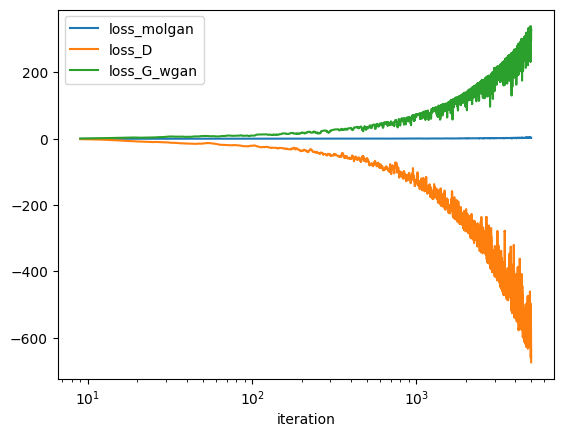

In [22]:
result_df=pd.DataFrame(result,index=["loss_molgan", "loss_V", "loss_D", "loss_G_wgan", "loss_RL", "loss_sum"]).T
ax=result_df.drop(columns=['loss_sum','loss_V','loss_RL']).rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-8,8))
ax.set_xlabel("iteration")

Text(0.5, 0, 'iteration')

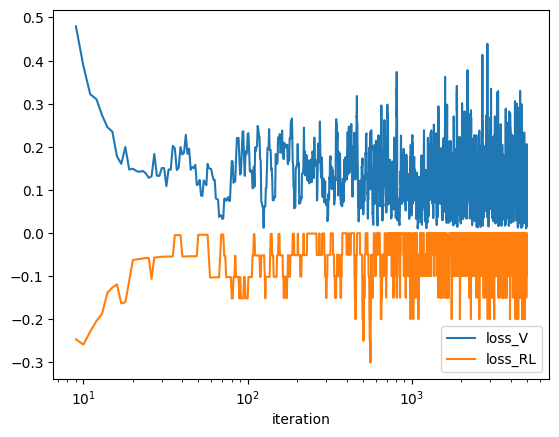

In [23]:
ax=result_df[['loss_V','loss_RL']].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-.6,.3))
ax.set_xlabel("iteration")

Text(0.5, 1.0, 'loss_molgan')

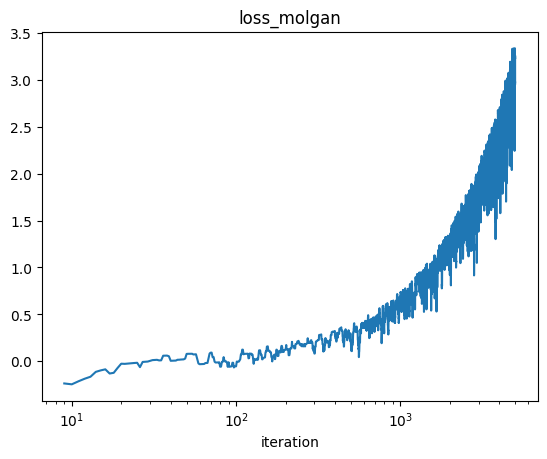

In [29]:
ax=result_df['loss_molgan'].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-10,10))
ax.set_xlabel("iteration")
ax.set_title("loss_molgan")

Text(0.5, 0, 'iteration')

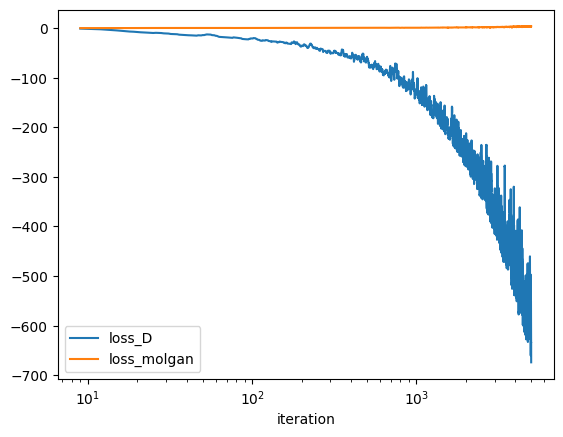

In [25]:
ax=result_df[['loss_D','loss_molgan']].rolling(window=10).mean().plot()
ax.set_xscale('log')
#ax.set_ylim((-.6,.3))
ax.set_xlabel("iteration")

In [ ]:
GP_LAMBDA

In [ ]:
with torch.no_grad():
    tmp=tqdm(range(10000))
    for _ in tmp:
        generated=solver.G(sample(Z_DIM))
        sampled_graph=sample_gumbel(*generated,hard=True)
        tmpmol=(mol_from_graph(*sampled_graph,print_errors=False))
        tmp.set_description(f'{sampled_graph[1][...,1:,:,:].sum()}')
        if tmpmol is not None:
            display(tmpmol)

In [27]:
best_mol=None
best_score=-100
with torch.no_grad():
    tmp=tqdm(range(10000))
    for _ in tmp:
        generated=solver.G(sample(Z_DIM))
        sampled_graph=sample_gumbel(*generated,hard=True)
        try:
            tmp_score=reward(mol_from_graph(*sampled_graph,strict=False)).item()
        except:
            tmp_score=0
        if (tmp_score)>best_score:
            best_score=tmp_score
            best_mol=sampled_graph
            tmp.set_description(f'{best_score} {sampled_graph[1][...,1:,:,:].sum()}')
            #display(mol_from_graph(*best_mol,strict=False))

0 54.0:  15%|██████████▏                                                         | 1489/10000 [00:02<00:17, 498.79it/s]

KeyboardInterrupt



In [ ]:
mol_from_graph(*sampled_graph,strict=False)

In [ ]:
mol_from_graph(*best_mol,strict=False)

In [ ]:
with torch.no_grad():
    print(solver.R(sampled_graph).item())

In [ ]:
from IPython.display import display
for generated_graph in zip(*generated):
    tmp=(sample_gumbel(*generated_graph))
    break

In [ ]:
mol_from_graph(*tmp,print_errors=True)

WGAN-GP formula

$\underset{G}{\min}\underset{D}{\max}{[D(x)-D(G(z))+\lambda(\nabla_\hat{x}||D(\hat{x})||_2-1)^2]};x\sim X;z\sim p(z)$